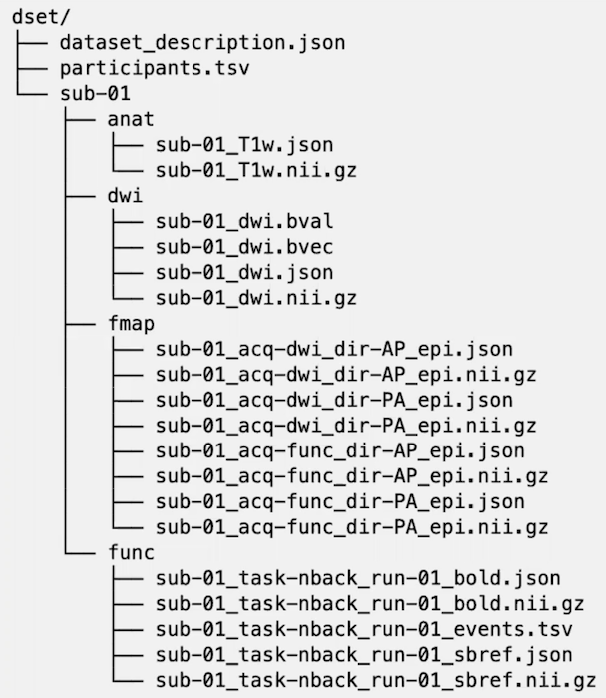

# BIDS: Brain Imaging Data Structure
* BIDS is a directory structure, based on common practices.
* Builds on existing standards (NIfTI, JSON, TSV)
* Intended for human and machine legibility
* The BIDS Validator makes compliance easy to verify
* The specification is a searchable HTML document
* Basic metadata in the file names
    * Subject, seesion, imaging modality, etc.
    * Generally just enough to assign unique names
* NIfTI headers and JSON sidecars contain detailed, image-related metadata.
* dataset_description.json, participants.tsv, sessions.tsv, and scans.tsv record study-level metatdata that may not be associated with specific images.

# Bidsification
* Constructing a BIDS dataset can be tedious and error-prone, so there are several converters.
* DICOM images store their relevant metadata internally, but naming conventions tend to be scanner/institution-specific.
* The Heuristic DICOM Converter (HeuDiConv) and bidsify allow you to specify the mapping and apply in bulk. Both build off of dcm2niix.

## ReproIn
* The ReproIn projects aims to standardize scanner conventions, to eliminate the need to rewrite these mappings.

# BIDS Validator
* The machine-readable structure makes validation possible
* Website validator: https://bids-standard.github.io/bids-validator/

# PyBIDS
* A common specification of neuroimaging datasets affords queries for and adaptation to the available data.
* PyBIDS is a Python library for querying and manipulating BIDS datasets

In [1]:
from bids import BIDSLayout
import nibabel as nib
layout = BIDSLayout('/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000228')
bold = layout.get(subject = 'pixar003', suffix = 'bold', extension = 'nii.gz')
bold

[<BIDSImageFile filename='/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000228/sub-pixar003/func/sub-pixar003_task-pixar_bold.nii.gz'>]

In [2]:
md = bold[0].get_metadata()
md['RepetitionTime']

2

In [3]:
bold[0].get_entities()

{'datatype': 'func',
 'extension': '.nii.gz',
 'subject': 'pixar003',
 'suffix': 'bold',
 'task': 'pixar'}

In [4]:
# get queries return all matching files:
layout.get(subject = 'pixar003')

[<BIDSJSONFile filename='/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000228/sub-pixar003/anat/sub-pixar003_T1w.json'>,
 <BIDSImageFile filename='/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000228/sub-pixar003/anat/sub-pixar003_T1w.nii.gz'>,
 <BIDSJSONFile filename='/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000228/sub-pixar003/func/sub-pixar003_task-pixar_bold.json'>,
 <BIDSImageFile filename='/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000228/sub-pixar003/func/sub-pixar003_task-pixar_bold.nii.gz'>]

In [ ]:
# Correct image headers from BIDS metadata
for bold_series in layout.get(suffix='bold', extension='nii.gz'):
    img = bold_series.get_image() #Returns nibabel image object
    zooms = img.header.get_zooms()
    zooms[3] = bold_series.get_metadata()['RepetitionTime']
    img.header.set_zooms(zooms)
    img.to_filename(bold_series)

# PyBIDS: entity queries
* Each file has a set of associated entities, such as subject, task, suffix or extension. You can query the layout for wat entities exist for any file:

In [8]:
layout.get_subjects()

['pixar001', 'pixar002', 'pixar003']

In [9]:
layout.get_tasks()

['pixar']

In [11]:
import bids
layout.get_suffixes(subject= bids.layout.Query.ANY)

['T1w', 'bold']

In [12]:
list(layout.get_entities(metadata=False))

['task', 'suffix', 'extension', 'subject', 'datatype']

# PyBIDS - Metadata queries
* BIDS specifies the Inheritance Principle:
    * Any metadata file [...] may be defined at any directory level [...]. The values from the top level are inherited by all lower levels unless they are overridden by a file at the lower level.

In [13]:
bold_file = layout.get(subject = 'pixar001', suffix = 'bold',
                       extension = ['nii', 'nii.gz'])[0]
md = bold_file.get_metadata()
md.keys()

dict_keys(['CogAtlasID', 'EchoTime', 'EffectiveEchoSpacing', 'FlipAngle', 'MagneticFieldStrength', 'Manufacturer', 'ManufacturersModelName', 'PhaseEncodingDirection', 'RepetitionTime', 'SliceTiming', 'TaskName', 'dcmmeta_affine', 'dcmmeta_reorient_transform', 'dcmmeta_shape', 'dcmmeta_slice_dim', 'dcmmeta_version', 'global', 'time'])

In [14]:
md['EchoTime']

0.03

In [15]:
md['FlipAngle']

90

In [ ]:
# Many metadata terms are optional in BIDS, so queries that may work smoothly in one dataset, or on one file, may fail on others:
md['SliceEncodingDirection']

In [19]:
# Like filename entities, metadata entities get convenience methods:
layout.get_FlipAngles()

[7, 90]

In [ ]:
layout.get_suffix(FlipAngle = 7)

In [ ]:
layout.get_suffix(FlipAngle = 88)

In [ ]:
layout.get_FlipAngle(suffix = 'bold')

In [20]:
# how common is each?
# key: value in the loop
{fa: len(layout.get(FlipAngle = fa))
 for fa in layout.get_FlipAngle(suffix = 'bold')}

{90: 3}

In [23]:
layout.get_subjects(FlipAngle=90)

['pixar001', 'pixar002', 'pixar003']

# PyBIDS - Tabular data
* The Midnight Scan Club dataset contains a lot of tabular data, so we will use that:

In [24]:
layout = BIDSLayout('/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000224')

In [27]:
# TSV files can be accessed just like NIfTI files, and their contents loaded as Pandas dataframes:
participants = layout.get(suffix='participants',extension = 'tsv')[0]
participants

<BIDSDataFile filename='/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000224/participants.tsv'>

In [28]:
participants.get_df()

,participant_id,gender,age,education_degree,education_years
0,sub-MSC01,M,34,Doctorate,22.0
1,sub-MSC02,M,34,Doctorate,28.0
2,sub-MSC03,F,29,Masters,18.0
3,sub-MSC04,F,28,Bachelors,22.0
4,sub-MSC05,M,27,Bachelors,20.0
5,sub-MSC06,F,24,Bachelors,17.5
6,sub-MSC07,F,31,Masters,20.0
7,sub-MSC08,F,27,Professional,21.0
8,sub-MSC09,M,26,Professional,19.0
9,sub-MSC10,M,31,Professional,19.0


## PyBIDS - Tabular data
PyBIDS can aggregate file metadata along with the `get_collections()` method

In [30]:
# This object is useful for manipulating the data programmatically, such as when running BIDS Statistical Models
collections = layout.get_collections(level='dataset')
collections

[<BIDSVariableCollection['age', 'education_degree', 'education_years', 'gender']>]

In [32]:
# For a more familiar interface, dataframes are retrievable.
# Note the suffix of the containing file is now a column, and the subject column has replaced participant_id 
# (and the sub- has beed dropped)
collections[0].to_df()

,subject,age,education_degree,education_years,gender,suffix
0,MSC01,34,Doctorate,22.0,M,participants
1,MSC02,34,Doctorate,28.0,M,participants
2,MSC03,29,Masters,18.0,F,participants
3,MSC04,28,Bachelors,22.0,F,participants
4,MSC05,27,Bachelors,20.0,M,participants
5,MSC06,24,Bachelors,17.5,F,participants
6,MSC07,31,Masters,20.0,F,participants
7,MSC08,27,Professional,21.0,F,participants
8,MSC09,26,Professional,19.0,M,participants
9,MSC10,31,Professional,19.0,M,participants


## PyBIDS - Tabular data
The subject level shows the subject's sessions.tsv:

In [33]:
layout.get_collections(level = 'subject', subject = 'MSC01')[0].to_df()

,subject,session,acq_time,suffix
0,MSC01,func01,1894-08-25T01:07:51,sessions
1,MSC01,func02,1894-08-26T00:09:21,sessions
2,MSC01,func03,1894-08-27T00:17:24,sessions
3,MSC01,func04,1894-08-28T00:14:11,sessions
4,MSC01,func05,1894-08-29T00:08:33,sessions
5,MSC01,func06,1894-08-30T00:12:32,sessions
6,MSC01,func07,1894-08-31T00:08:55,sessions
7,MSC01,func08,1894-09-08T00:18:53,sessions
8,MSC01,func09,1894-09-09T00:15:21,sessions
9,MSC01,func10,1894-09-10T00:18:59,sessions


## PyBIDS - Tabular data:
The session level shows the scans in the session:

In [43]:
# Note that metadata from *_bold.json (TaskName + ~ 20 columns) is also here.
layout = BIDSLayout('/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000224')
layout.get_collections(level = 'session', subject = 'MSC01', session = 'func01')[0].to_df()

,run,subject,session,BodyPartExamined,CogAtlasID,ConversionSoftware,ConversionSoftwareVersion,EchoTime,EffectiveEchoSpacing,FlipAngle,...,SequenceName,SequenceVariant,SeriesDescription,SliceTiming,SoftwareVersion,TaskName,acq_time,task,suffix,datatype
0,1.0,MSC01,func01,HEAD,http://www.cognitiveatlas.org/task/id/trm_4f24...,dcm2niix,v1.0.20170411 GCC4.4.7,0.027,0.00059,90,...,_epfid2d1_64,SK,MixedDesign_192Frames_36Slices_TR2.2,"[1.105, 0, 1.1675, 0.0625, 1.2275, 0.1225, 1.2...",syngo MR B17,glasslexical,1894-08-25T02:44:47,glasslexical,bold,func
1,2.0,MSC01,func01,HEAD,http://www.cognitiveatlas.org/task/id/trm_4f24...,dcm2niix,v1.0.20170411 GCC4.4.7,0.027,0.00059,90,...,_epfid2d1_64,SK,MixedDesign_192Frames_36Slices_TR2.2,"[1.105, 0, 1.1675, 0.0625, 1.2275, 0.1225, 1.2...",syngo MR B17,glasslexical,1894-08-25T02:53:17,glasslexical,bold,func


## PyBIDS - Tabular data
The run level collects data from events.tsv, *_physio.tsv.gz, *_stim.tsv.gz or * *_regressors.tsv

In [ ]:
layout.get_collections(level='run', subject='MSC01',session = 'func01',
                       task = 'motor', run=1)[0].to_df()

# PyBIDS - Generating data
PyBIDS has the capability to generate filenames, if you need to add metadata to a dataset

In [45]:
# Adding entities produces more complex filenames
import json
layout = BIDSLayout('/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000228')
entities = {"task": "rest", "suffix": "bold", "extension": "json"}
layout.build_path(entities)

'/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000228/task-rest_bold.json'

In [46]:
layout.write_contents = json.dumps({"Instructions": "Just relax."})

In [ ]:
# Summaries of the data can also be generated
# BIDSReport is something that takes a layout and it generates a collection of reports describing your data
from bids.reports import BIDSReport
reports = BIDSReport(layout).generate()
print(reports.most_common()[0][0])

# PyBIDS - Final thoughts
Many grad students have written a large subset of the preceding for their own labs.
* File structure, mirroring inputs/outputs of the preferred tool suite (FreeSurfer, AFNI, etc.)
* A metadata folder, file or database, containing study parameters and individual subject/session details
* A library of functions for fetching files, metadata, computing data, and saving results

Each lab's pipelines are inevitably idiosyncratic, and to reproduce with someone else's data, the data must be reformatted to fit code expectations, or the code must be modified to handle the new structure.

By standardizing on a data structure, code written to that structure gains stability and broad applicability.

----

BIDS-MATLAB is a similar project for MATLAB/Octave

# BIDS Applications
A common specification of neuroimaging datasets affords queries for and adaptation to the available data

Queryable (meta)data allows a very simple protocol for a BIDS App:
bids-app /bids-directory /output-directory participant [OPTIONS]

Examples:

MRIQC (Quality Control)

mriac /data/bids/openneuro/ds000228 /data/processed/ds000228-mriqc group

fMRIPrep

fmriprep /data/bids/openneuro/ds000228 /data/processed/ds000228-fmriprep \ participant --participant-label pixar001

### Many application types are possible
* Quality control
* Anatomical pipelines
* Functional pipelines
* Diffusion pipelines

### Lowered friction encourages adoption
* Researchers gain easy access to tools by formatting data in BIDS
* Accepting BIDS datasets makes your tools easy to try

## Example: summarize scan parameters
A short program to summarize variations in scan parameters across subjects.

In [ ]:
import sys
from pathlib import Path
from bids import BIDSLayout
from bids.reports import BIDSReport

# Collect the command-line arguments to implement the BIDS Apps protocal.
# There are libraries to help add options, but this is the heart of it.
cmd, bids_root, out_root, analysis_level, *opts = sys.argv
layout = BIDSLayout(bids_root)

# Generate a report per subject. Add the subject to a list associated with report text.
reports= {}
for subject in layout.get_subjects():
    rep = list(BIDSReport(layout).generate(subject = subject))[0]
    reports.setdefault(rep, []).append(subject)

# Write the number of scans parameter sets to a report file, then for each set 
# and report which subjects had the same parameters, and what they were
with open(Path(out_root) / 'report.txt', 'w') as out_file:
    out_file.write(f"Scan parameter sets detected: {len(reports)}\n\n")
    for rep, subs in reports.items():
        rep = "\n".join(rep.splitlines()[:-2])
        out_file.write(f"-----\nParameters for subjects: {', '.join(subs)}\n\n")
        out_file.write(rep.replace('<deg>', "∘") + "\n\n")

### BIDS Applications
For development and distribution, BIDS Apps encourages a continuous-integraion (CI) approach.

The uniform interface also eases deployment to HPC or cloud environments like CBRAIN or AWS Batch.

BIDS Apps use the notion of analysis level, which provide natural opportunities for parallelism.

# BIDS Apps and Reproducibility
Start-to-finish pipelines aid in performing reproducible analyses.

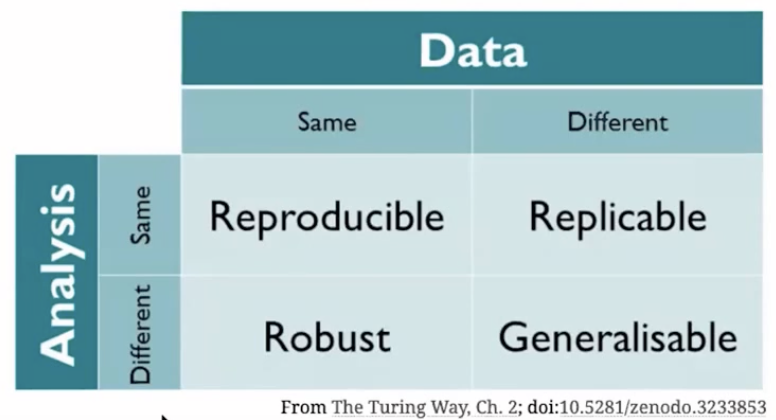

Open analysis on open data is subject to independent reproduction.

Accepting BIDS datasets makes replicating results on independent data easier.

A common interface also makes independent analyses easier to write and compare.

Reuseable code is only one part of reproducibility. Does it always produce the same result?

Sources of variability:
* Operating system (version)
* Dependency versions
* Stochastic (random) components

Container technologies partially address environmental sources of variability. The Neurodocker project aims to make the creation of consistent environment simpler.

Tools for quantifying run-to-run reproducibility are in progress.

# BIDS Derivatives
The output of a BIDS App is a derivative dataset. The BIDS standard is being extended to describe many types of derivates, with a focus on derivatives that can be reused in yet more BIDS apps.

Dataset-level metadata is stored in augmented dataset_description.json:
* PipelineDescription contains references to the code (including version) that produced the derivative dataset.
* SourceDatasets is a list of references to the specific version of the dataset analyzed

Basic metadata remains in filenames

Additional metadata in sidecar JSON files
* Sources: input files to the process that produced the file
* SpatialReference: structureal images/surfaces needed for interpretation

Derivative generally fall into three categories:
1. Preprocessed images (or otherwise transformed data) that can be used for further analysis
    * Tissue segmentations
    * Normalized BOLD series
    * Fitted diffusion model parameters
2. Measures of statistics of interest
    * Parcellation statistics
    * Local functional connectivity density
    * Fractional anisotropy
3. Figures and reports for assessing the quality of data/processing